# Imports and Setup

In [1]:
from __future__ import annotations
from collections import defaultdict
from functools import partial
import os
import pathlib

from avm_stats.extract_proto import *
from avm_stats.proto_helpers import *
from avm_stats.yuv_tools import *
from avm_stats.frame_visualizations import *
import matplotlib.pyplot as plt

if "AOM_BUILD_DIR" not in os.environ:
  raise RuntimeError("Please set AOM_BUILD_DIR environment variable before launching.")
AOM_BUILD_DIR = pathlib.Path(os.environ["AOM_BUILD_DIR"])

if "LIBAOM_TEST_DATA_PATH" not in os.environ:
  raise RuntimeError("Please set LIBAOM_TEST_DATA_PATH environment variable before launching.")
LIBAOM_TEST_DATA_PATH = pathlib.Path(os.environ["LIBAOM_TEST_DATA_PATH"])

DEFAULT_WORKING_DIR = "/tmp/frame_vis_notebook"
JUPYTER_WORKING_DIR = pathlib.Path(os.getenv("JUPYTER_WORKING_DIR", DEFAULT_WORKING_DIR))

os.makedirs(JUPYTER_WORKING_DIR.name, exist_ok=True)

extract_proto_bin = AOM_BUILD_DIR / "extract_proto"

print(f"Using extract_proto binary: {extract_proto_bin}")
print(f"Using working dir: {JUPYTER_WORKING_DIR}")

Using extract_proto binary: /tmp/build/extract_proto
Using working dir: /tmp/frame_vis_notebook


# Extract And Load A Sample Stream

In [2]:
stream_path = LIBAOM_TEST_DATA_PATH / "park_joy_90p_8_420.ivf"
yuv_path = LIBAOM_TEST_DATA_PATH / "park_joy_90p_8_420.y4m"
print(f"Using sample stream: {stream_path}")

frames = extract_and_load_protos(extract_proto_path = extract_proto_bin,
    stream_path = stream_path,
    output_path = JUPYTER_WORKING_DIR,
    skip_if_output_already_exists = False,
    yuv_path = yuv_path)

seq = list(frames)
num_frames = len(seq)
print(f"Loaded {num_frames} frame protos.")

Using sample stream: /tmp/testdata/park_joy_90p_8_420.ivf
Loaded 2 frame protos.


# Plot luma plane of each frame, comparing: Original, Prediction, Residual, Prefiltered Reconstruction, Reconstruction and Distortion

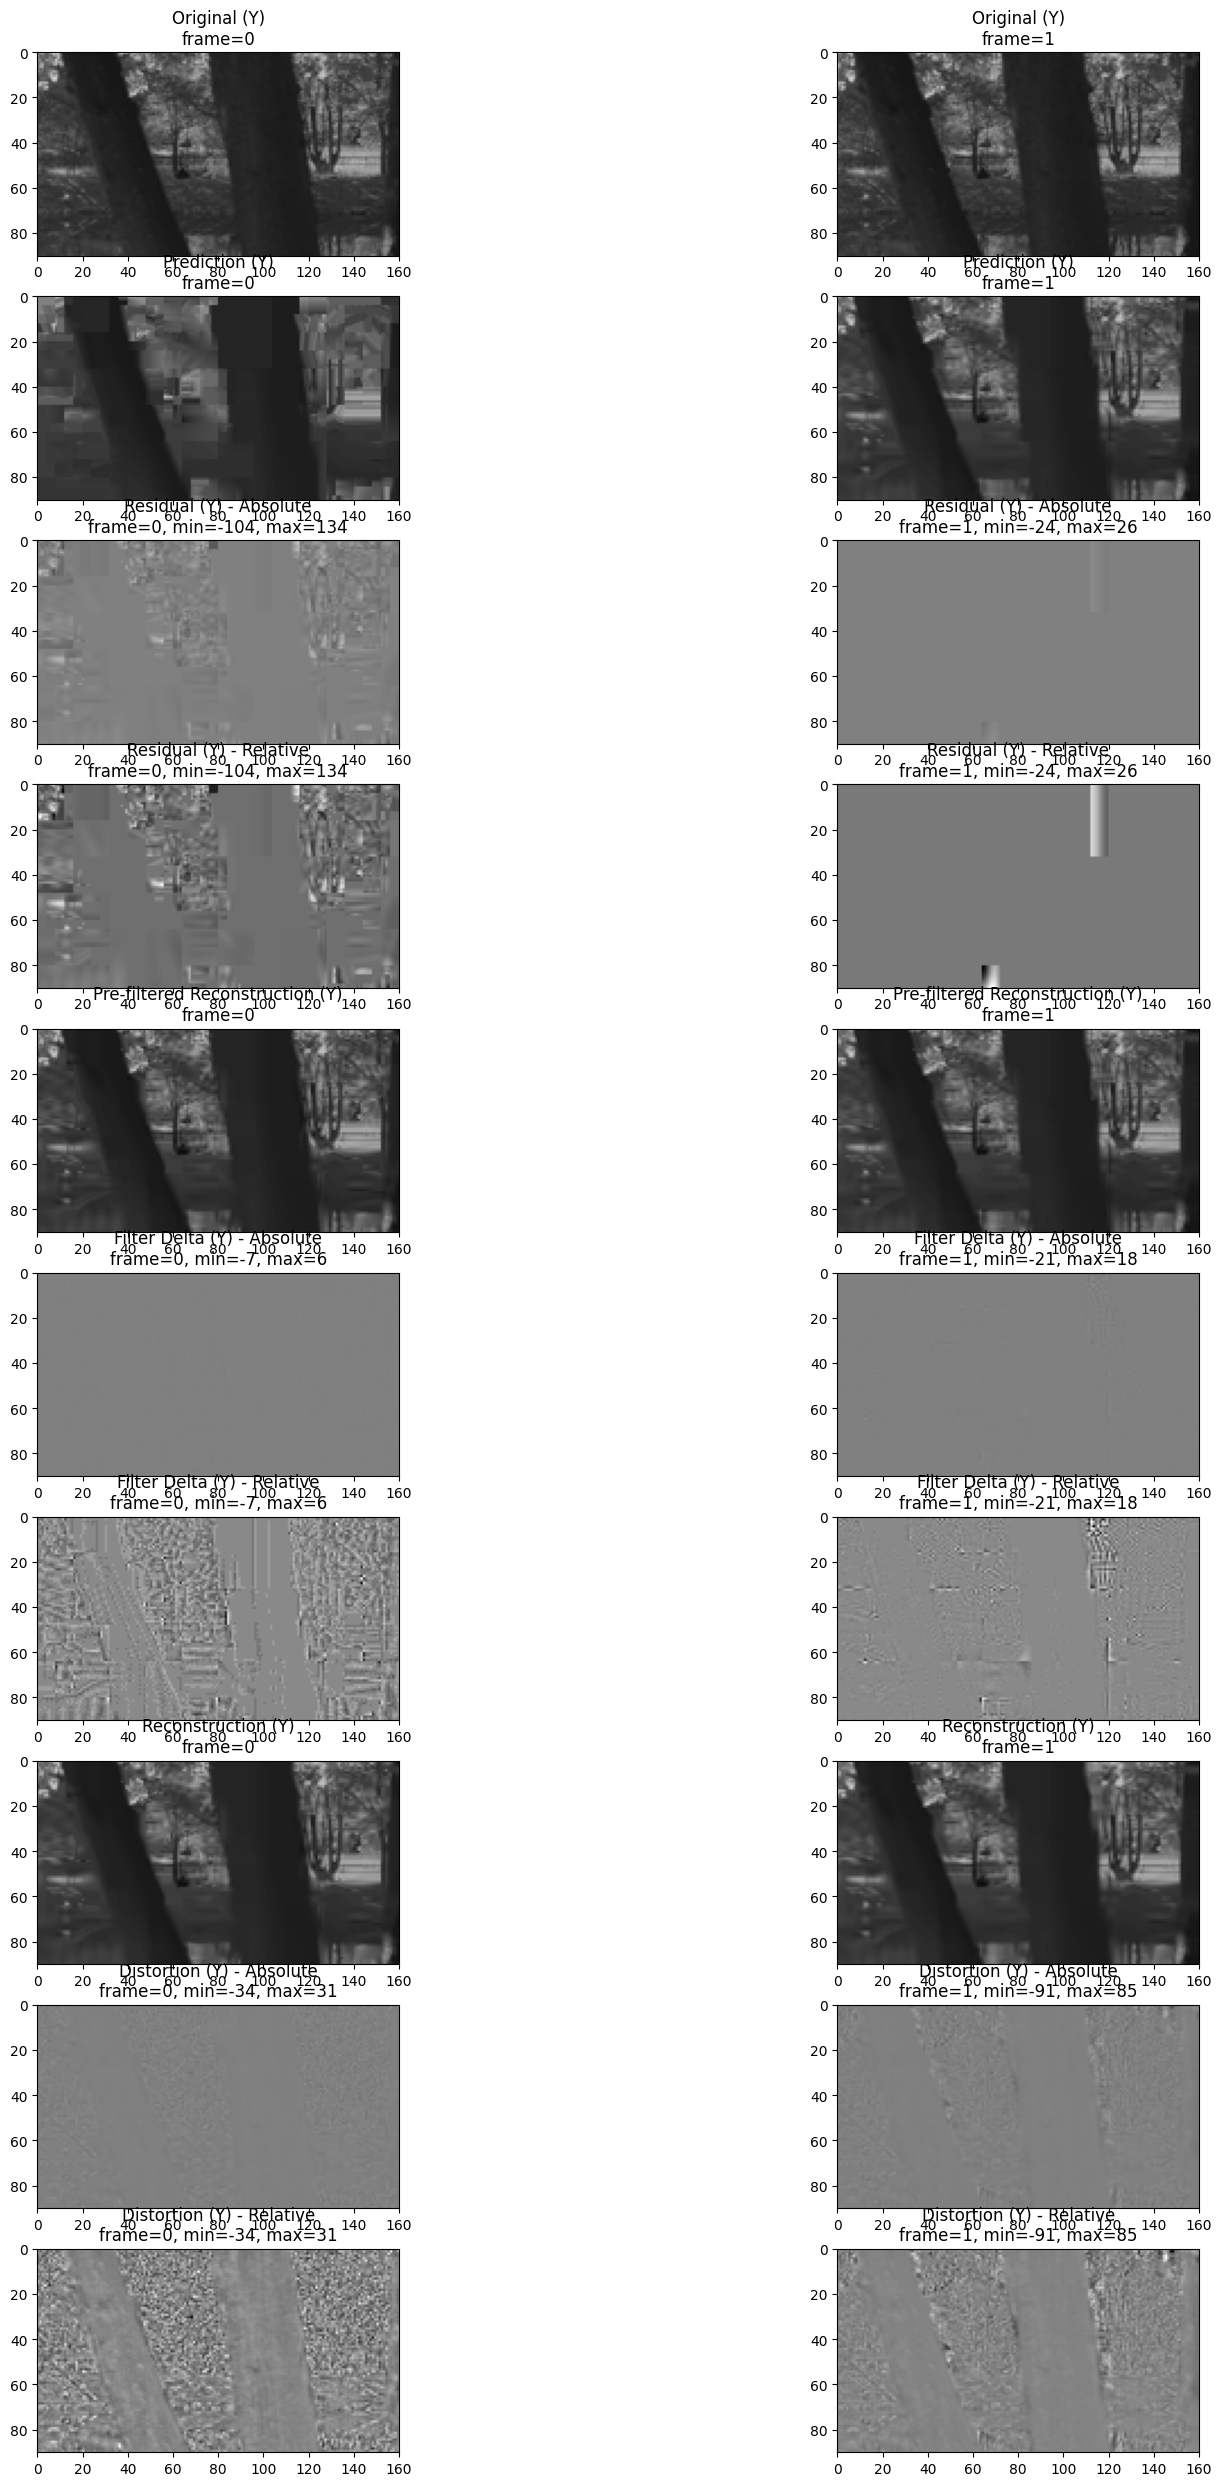

In [3]:
visualizations = [
    OriginalYuvLayer,
    PredictionYuvLayer,
    partial(ResidualYuvLayer, show_relative=False),
    partial(ResidualYuvLayer, show_relative=True),
    PrefilteredYuvLayer,
    partial(FilterDeltaYuvLayer, show_relative=False),
    partial(FilterDeltaYuvLayer, show_relative=True),
    ReconstructionYuvLayer,
    partial(DistortionYuvLayer, show_relative=False),
    partial(DistortionYuvLayer, show_relative=True),
]

fig, axes = plt.subplots(len(visualizations), num_frames, figsize = (16, 24))
plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1.0,
                    top=1.0,
                    wspace=0.0,
                    hspace=0.2)

for i, frame in enumerate(seq):
  for j, vis in enumerate(visualizations):
    vis().show(frame, axes[j][i])


# Plot Partition Tree + Motion Vectors

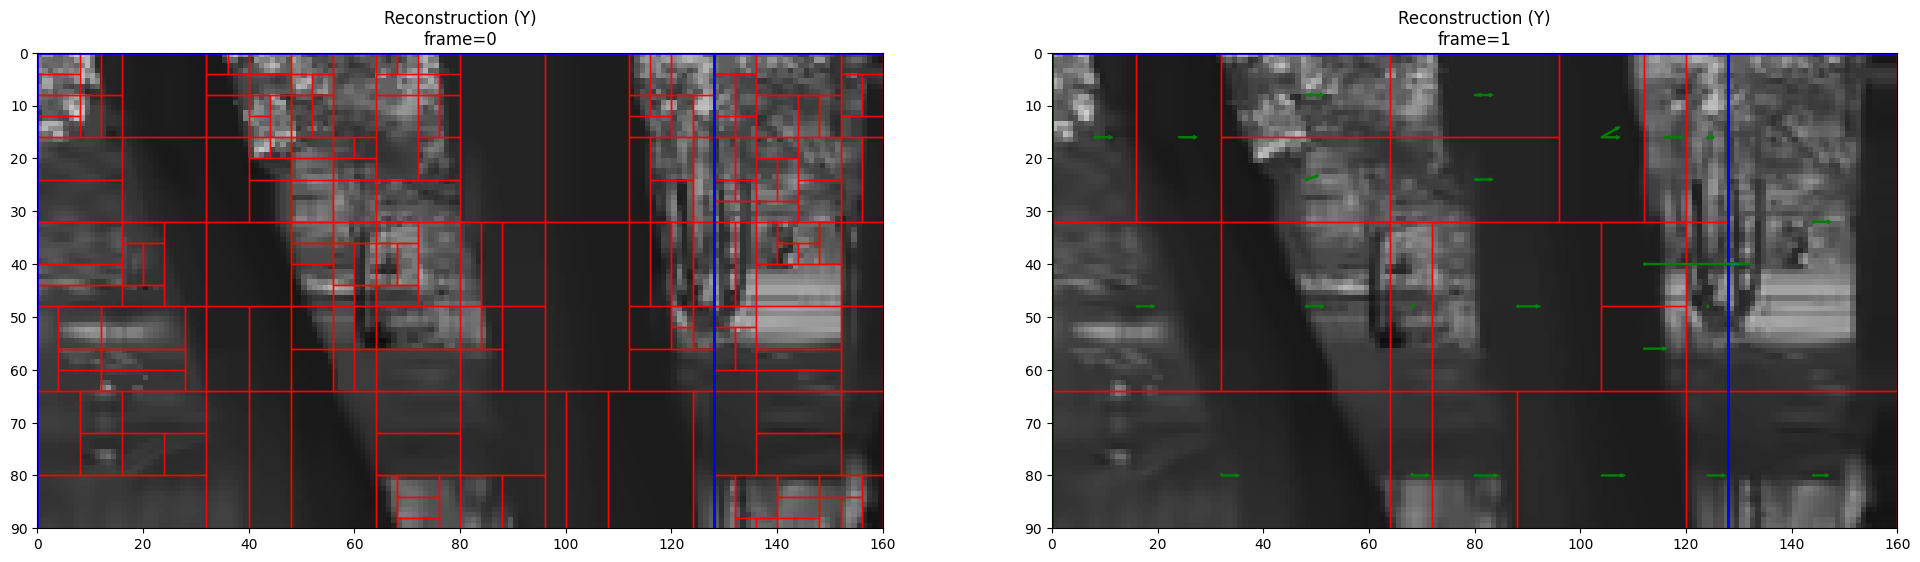

In [4]:
fig, axes = plt.subplots(1, num_frames, figsize = (24, 24))
vis_y = ReconstructionYuvLayer().add(PartitionTreeLayer()).add(SuperblockLayer()).add(MotionVectorLayer())

for i, frame in enumerate(seq):
  vis_y.show(frame, axes[i])


# Heatmap of where bits are used within each frame

Available symbols:
av1_read_cctx_type av1_read_coeffs_txb av1_read_coeffs_txb_skip av1_read_pb_mv_precision av1_read_sec_tx_type av1_read_sig_txtype av1_read_tx_type decode_eob loop_restoration_read_sb_coeffs read_block_reference_mode read_ccso read_cdef read_cfl_alphas read_cfl_index read_coeff_hidden read_coeffs_forward_2d read_coeffs_reverse read_coeffs_reverse_2d read_drl_idx read_filter_intra_mode_info read_fsc_mode read_inter_block_mode_info read_inter_compound_mode read_inter_mode read_interintra_mode read_intra_luma_mode read_intra_uv_mode read_is_inter_block read_mb_interp_filter read_mh_dir read_motion_mode read_mrl_index read_mv read_mv_component read_partition read_secondary_tx_set read_skip_txfm read_tx_partition read_wedge_mode
Frame 0, Bits for read_coeffs: 4384.215072631836 (55.06%)
Frame 1, Bits for read_coeffs: 9.649810791015625 (2.32%)


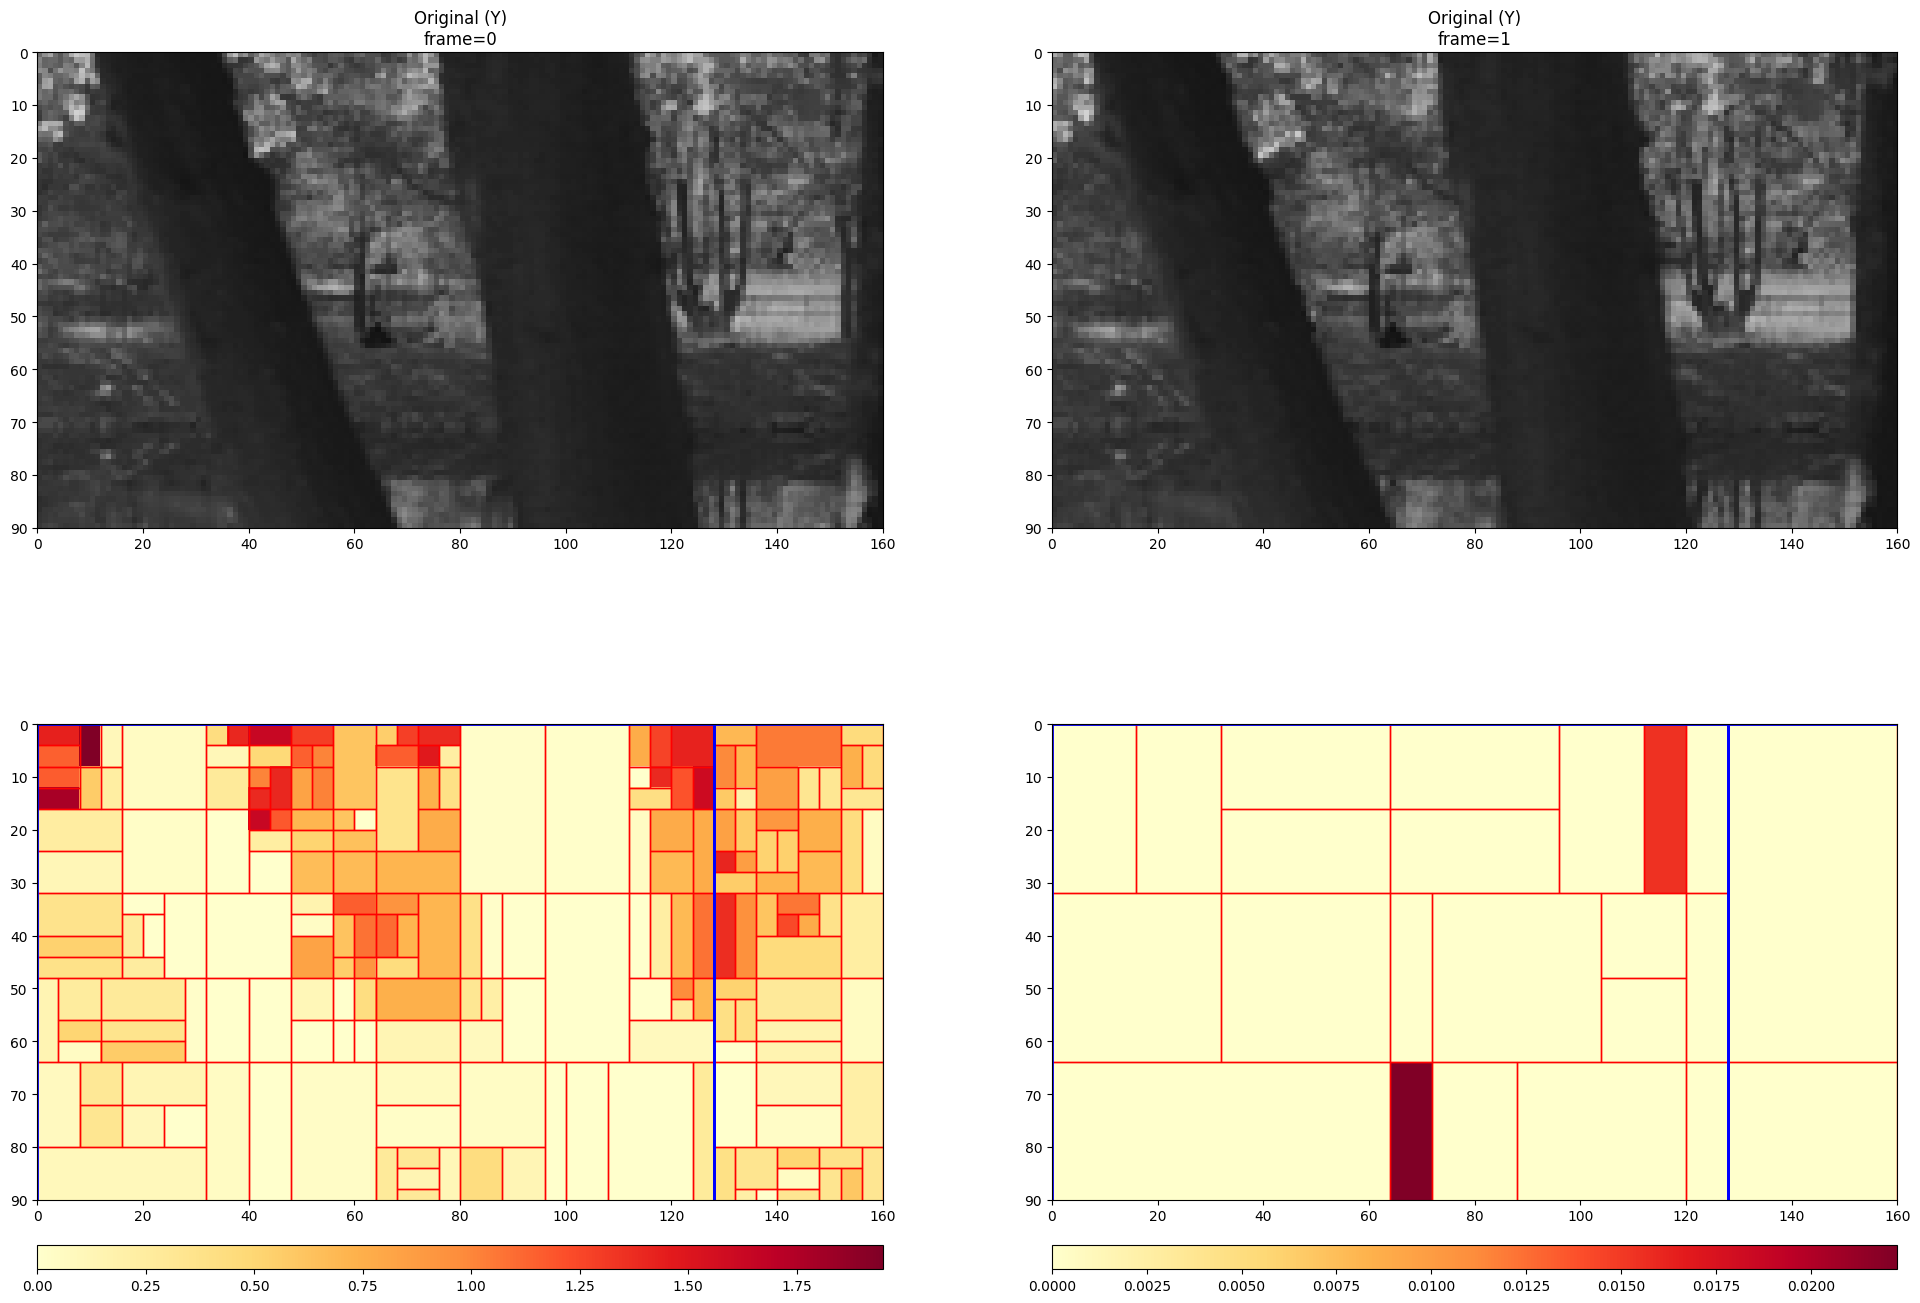

In [5]:
# Edit this to change the symbol filter in the heatmap plot, or set to None to show all bits:
symbol_filter = "read_coeffs"
# symbol_filter = "read_intra_luma_mode"
# symbol_filter = None

c_funcs = set()
for frame in seq:
  c_funcs |= set(i.source_function for i in frame.proto.symbol_info.values())
print("Available symbols:")
print(" ".join(sorted(c_funcs)))

fig, axes = plt.subplots(2, num_frames, figsize = (24, 16))
for i, frame in enumerate(seq):
  def my_filter(sym: Symbol):
    return symbol_filter in sym.source_function or symbol_filter is None
  OriginalYuvLayer().show(frame, axes[0][i])
  BitsHeatmapLayer(filt = my_filter).add(PartitionTreeLayer()).add(SuperblockLayer()).show(frame, axes[1][i])
  total_bits = 0
  bits_for_symbol = 0
  for sb in frame.superblocks:
    total_bits += sb.get_total_bits()
    bits_for_symbol += sb.get_total_bits(use_chroma=False, filt=my_filter)
  if symbol_filter:
    percent = 100.0 * bits_for_symbol / total_bits
    print(f"Frame {i}, Bits for {symbol_filter}: {bits_for_symbol} ({percent:.2f}%)")
plt.show()




# Plot intra mode per block

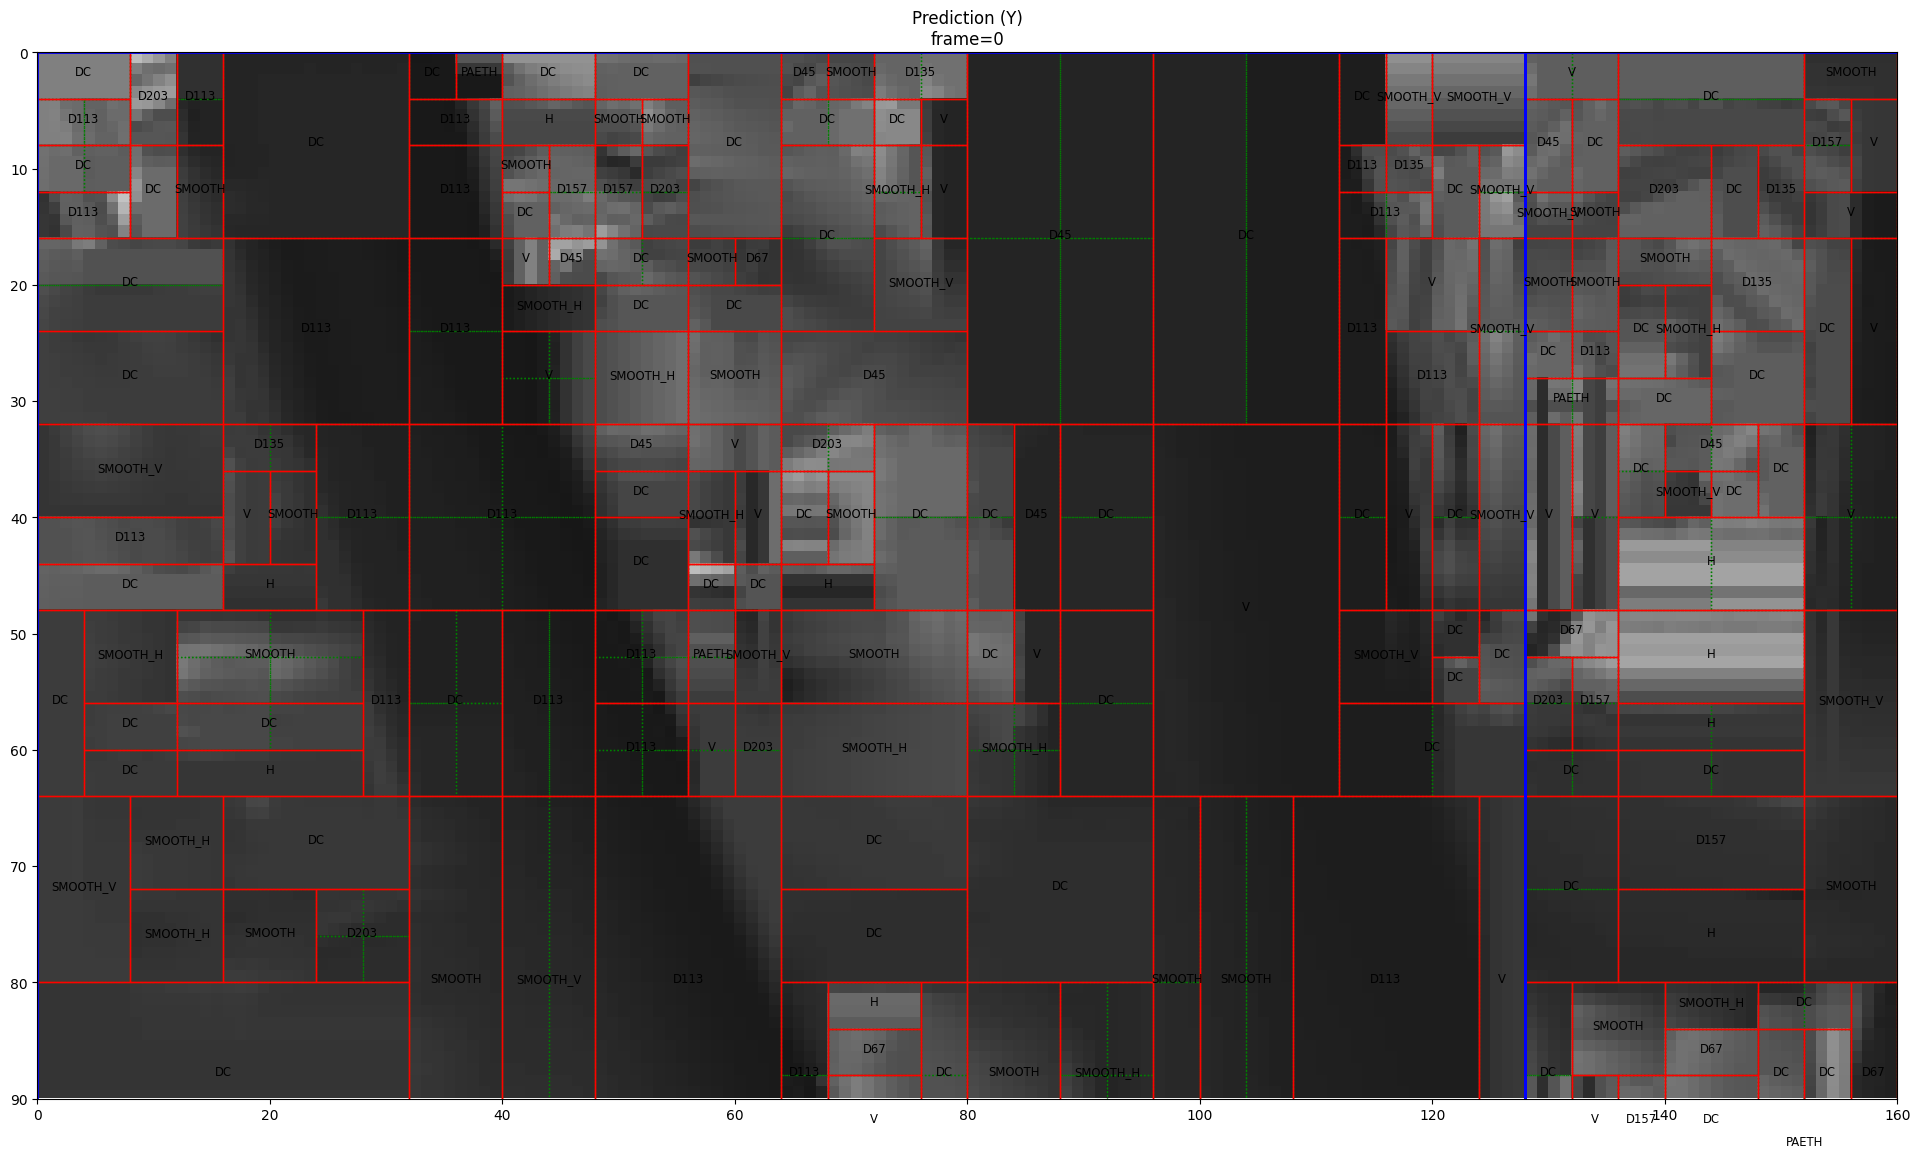

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (24, 24))
vis = PredictionYuvLayer().add(TransformBlockLayer()).add(PartitionTreeLayer()).add(SuperblockLayer()).add(PredictionModeAnnotationLayer())
vis.show(seq[0], ax)

# Distribution of intra modes

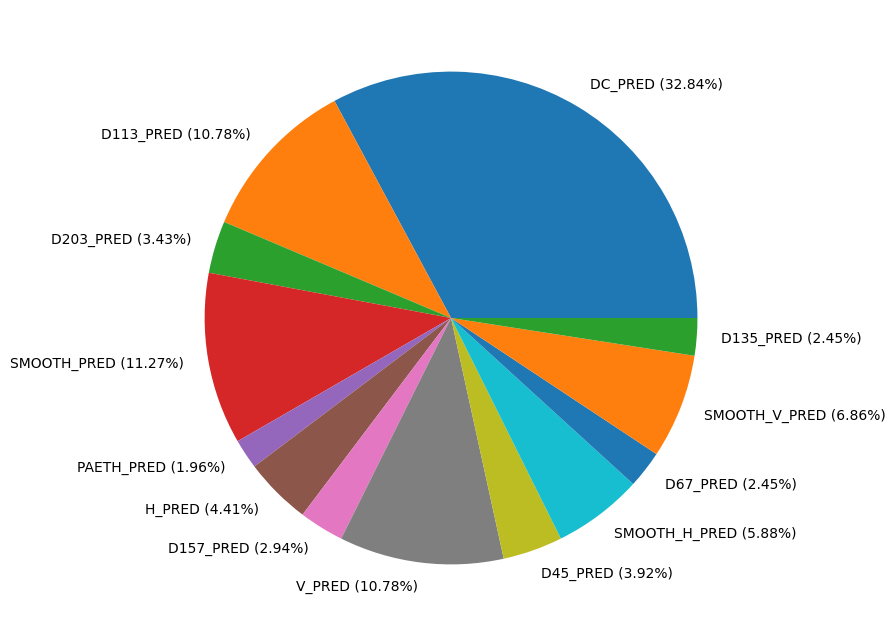

In [7]:
mode_counts = defaultdict(int)
for sb in seq[0].superblocks:
  for cu in sb.get_coding_units():
    mode_counts[cu.get_prediction_mode()] += 1
total = sum(mode_counts.values())
keys = mode_counts.keys()
labels = [f"{k} ({100.0*mode_counts[k]/total:.2f}%)"for k in keys]
sizes = [mode_counts[k] for k in keys]

fig, ax = plt.subplots(figsize =(8,8))
ax.pie(sizes, labels=labels);